In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
%matplotlib inline
plt.style.use("seaborn")
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
data = pd.read_csv("./datasets/Metro_time_series.csv")

In [3]:
cols = ['Date', 'RegionName', 'ZHVI_AllHomes']
data = data[data['ZHVI_AllHomes'] > 0]
data = data.filter(cols)
data = data.rename(columns={"RegionName": "CBSA_Code"})
cityList = np.unique(data['CBSA_Code'])
metro = []
for code in tqdm(cityList):
    metro.append(data[data['CBSA_Code']  == str(code)])


100%|██████████| 730/730 [00:05<00:00, 132.02it/s]


In [6]:
def movingAverage_normalize(a, n=5) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    moving_avg = ret[n - 1:] / n
    return np.array([(x-np.mean(moving_avg))/np.std(moving_avg) for x in moving_avg])
#fig, ax = plt.subplots()
#ax.scatter(pd.to_datetime(city1['Date'][4:]).dt.date, movingAverage_normalize(city1['ZHVI_AllHomes'].values))
#plt.show()
movingAverage_normalize(city1['ZHVI_AllHomes'].values)
# don't send moving average 
#  CHECK IF AFFECTS MOVING AVERAGE AFFECTS ARIMA

array([-1.52245317, -1.46376916, -1.41346858, -1.37993486, -1.36526386,
       -1.36631179, -1.37155143, -1.38517451, -1.41137273, -1.43547509,
       -1.44805023, -1.45957745, -1.46796088, -1.47424845, -1.48891945,
       -1.51826146, -1.55179518, -1.58847268, -1.61991055, -1.64610876,
       -1.67021113, -1.69221763, -1.70374485, -1.70164899, -1.68278627,
       -1.64925255, -1.60628747, -1.55913068, -1.51721353, -1.48787152,
       -1.46796088, -1.4470023 , -1.41870823, -1.37783901, -1.31810707,
       -1.24684791, -1.17768462, -1.11690475, -1.07079589, -1.03621424,
       -0.99744087, -0.94714029, -0.88950421, -0.8308202 , -0.78575927,
       -0.75956105, -0.74803383, -0.75012969, -0.76480069, -0.78156755,
       -0.78890305, -0.78995098, -0.79309477, -0.79099891, -0.78261548,
       -0.78156755, -0.78051962, -0.77108826, -0.76270484, -0.76165691,
       -0.76794448, -0.78051962, -0.79309477, -0.8088137 , -0.82138884,
       -0.8234847 , -0.82767642, -0.84549121, -0.86854564, -0.89

              Date CBSA_Code  ZHVI_AllHomes
48      1996-04-30     13020        65200.0
732     1996-05-31     13020        65400.0
1419    1996-06-30     13020        65900.0
2107    1996-07-31     13020        66300.0
2796    1996-08-31     13020        66700.0
...            ...       ...            ...
206695  2017-08-31     13020        89200.0
207606  2017-09-30     13020        89100.0
208517  2017-10-31     13020        89900.0
209428  2017-11-30     13020        90800.0
210339  2017-12-31     13020        91600.0

[261 rows x 3 columns]


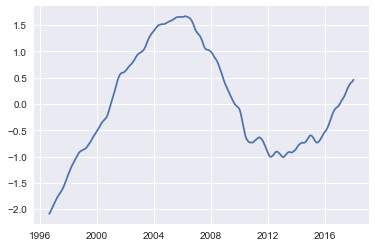

In [7]:
city1 = metro[0]
ames = data[data.CBSA_Code == '13020']
print(ames)
fig, ax = plt.subplots()
ax.plot(pd.to_datetime(ames['Date'][4:]).dt.date, movingAverage_normalize(ames['ZHVI_AllHomes'].values))
# ax.scatter(pd.to_datetime('2009-05-31'), ames[ames['Date'] == '2009-05-31']['ZHVI_AllHomes'])

In [24]:
THRESHOLD = 1

# def find_max_start(city):
#     return type == str

def find_start(city):
    """
    returns recession start date, measured as the largest local maximum ZHVI for a given city
    takes: city (pd.dataframe) [Date, ZHVI_avg_norm]
    returns: start_date (pd.datetime)
    """
    last_date = city.sort_values('Date', ascending=False).iloc[0]['Date']
    city = city[city['Date'] < '2015']
    d = lambda i: city['ZHVI_AllHomes'].iloc[i] - city['ZHVI_AllHomes'].iloc[i-1]
    diffs = np.array([d(i) for i in range(1, len(city))])
    # reshape dataframe to include diffs
    city = city.iloc[1:]
    city['Diffs'] = diffs
    # find local maxes using diffs
    is_max = np.array([(city['Diffs'].iloc[i] >= 0) 
                       and (city['Diffs'].iloc[i+1] <= 0) 
                       and (city['Diffs'].iloc[i+1] - city['Diffs'].iloc[i] <= THRESHOLD) for i in range(len(city) - 1)])
    is_max = np.append(is_max, False)

    # check for presence of local maxes at all
    if np.count_nonzero(is_max) == 0:
        return last_date
    # add 'is_maximum' truth column to dataframe
    city['Max'] = is_max
    # filter and find largest max
    theMax = city[city['Max'] == 1.0].sort_values("ZHVI_AllHomes", ascending=False).iloc[0]
    start_date = theMax['Date']
    return start_date

In [25]:
failed_cities = []
def ARIMA_50(city, start, params=(5,1,1)):
    """
    Params:
    city -- time-series dataframe object containing Date and ZHVI columns
    start -- datetime object from index of city representing peak ZHVI
    params -- p, d, and q parameters for ARIMA
    """
    
    #add start.dt.strftime('%Y-%m-%d') to convert datetime to string
    
    from statsmodels.tsa.arima_model import ARIMA
    
    before = city[['Date', 'ZHVI_AllHomes']]
#     print(before.shape, start)
    before = before[before['Date'] < start].set_index(['Date'])['ZHVI_AllHomes'].values
    steps = city.shape[0] - before.shape[0]
    try:
        model = ARIMA(before, order=(5, 1, 1))
        model_fit = model.fit(disp=0)
        return model_fit.forecast(steps)[0]
    except:
        failed_cities.append(np.unique(city.CBSA_Code)[0])
        return np.repeat(city[city['Date'] == start].ZHVI_AllHomes, steps)

In [26]:
def find_end(city, start, ARIMA_50):
    """
    returns recession end date, measured as the first point of intersection between ZHVI and ARIMA_50 for a given city
    takes: city (pd.dataframe) [Date, ZHVI_avg_norm], ARIMA_50 (pd.dataframe) [Date, forecasted_ZHVI_norm] 
    returns: end_date (pd.datetime)
    """
    # calculate diffs
    recession_ZHVI = city[city['Date'] >= start]
    diffs = ARIMA_50 - recession_ZHVI['ZHVI_AllHomes'].values
    city_resid = pd.DataFrame(data={'Date': recession_ZHVI['Date'].values, 'Delta': diffs})
    # filter only positive residuals, and most recent one is the last recession date
    most_recent_positive_delta = city_resid[city_resid['Delta'] > 0].sort_values("Date", ascending=False)
   # if ARIMA model indicates a sharp drop, set end date as one month after start date
    if (most_recent_positive_delta.shape[0] == 0):
        return city_resid.Date.values[0]
    end_date = most_recent_positive_delta['Date'].iloc[0]
#     print(end_date)
    return end_date

In [27]:
def calc_resid(city, predicted, start, end):
    """
    Params:
    city -- time-series dataframe object containing Date and ZHVI columns
    predicted -- predicted values from max to last date of city time-series
    max -- datetime object from index of city representing peak ZHVI
    end -- datetime object from index of city representing intersection of 
    actual and predicted ZHVI or last date of actual
    """
    
    # get indices of start and end date and use those to splice arrays
    recession_ZHVI = city[city['Date'] >= start]
    recession_ZHVI = recession_ZHVI[recession_ZHVI['Date'] < end]
    end_index = len(recession_ZHVI)
    predicted_to_end = predicted[:end_index]
    diffs = predicted_to_end - recession_ZHVI['ZHVI_AllHomes'].values
    return sum(diffs)

In [28]:
def find_AU3(metro):
#     print("City: {}".format(np.unique(metro.CBSA_Code)))
    start = find_start(metro)
    arima = ARIMA_50(metro, start)
#     print("Start Date: ", start)
#     fig, ax = plt.subplots()
#     ax.plot(pd.to_datetime(metro['Date'][4:]).dt.date, movingAverage_normalize(metro['ZHVI_AllHomes'].values))
#     print(metro[metro['Date'] > start].shape)
    end = find_end(metro, start, arima)
#     print("End Date: ", end)
    return calc_resid(metro, arima, start, end)

In [29]:
AU3_output = list(map(find_AU3, metro))

(239, 2) 2007-08-31
2017-12-31
(261, 2) 2014-03-31
2015-04-30
(261, 2) 2006-01-31
2017-12-31
(261, 2) 2007-04-30
2017-12-31
(261, 2) 2008-03-31
2017-12-31
(261, 2) 2007-11-30
2017-12-31
(261, 2) 2007-09-30
2017-12-31
(261, 2) 2007-11-30
2017-12-31
(261, 2) 2009-05-31
2017-12-31
(261, 2) 2010-02-28
2016-03-31
(239, 2) 2007-04-30
2017-12-31
(261, 2) 2007-06-30
2017-12-31
(245, 2) 2006-06-30
2017-12-31
(261, 2) 2007-02-28


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-31
(261, 2) 2003-10-31
2017-12-31
(261, 2) 2007-12-31
2017-12-31
(89, 2) 2010-11-30
2017-12-31
(261, 2) 2009-10-31
2017-12-31
(233, 2) 2008-06-30
2017-12-31
(71, 2) 2013-07-31
2017-12-31
(261, 2) 2006-07-31
2017-12-31
(261, 2) 2005-04-30


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-31
(261, 2) 2010-12-31
2017-12-31
(251, 2) 2006-05-31
2017-12-31
(261, 2) 2012-03-31
2015-06-30
(113, 2) 2009-02-28
2017-12-31
(261, 2) 2008-03-31
2017-12-31
(261, 2) 2003-11-30
2017-12-31
(261, 2) 2006-05-31
2017-12-31
(94, 2) 2012-08-31
2017-02-28
(261, 2) 2009-07-31
2017-12-31
(261, 2) 2008-02-29
2017-12-31
(261, 2) 2006-11-30
2017-12-31
(261, 2) 2006-05-31
2017-12-31
(261, 2) 2005-08-31
2017-12-31
(261, 2) 2009-11-30
2017-12-31
(261, 2) 2008-02-29
2017-12-31
(261, 2) 2011-06-30
2017-12-31
(261, 2) 2006-09-30


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-31
(245, 2) 2006-06-30
2017-12-31
(94, 2) 2011-05-31
2012-01-31
(261, 2) 2007-07-31
2017-12-31
(261, 2) 2006-06-30
2017-12-31
(261, 2) 2006-11-30
2017-12-31
(261, 2) 2006-03-31
2017-12-31
(261, 2) 2009-11-30
2017-12-31
(261, 2) 2006-03-31
2017-12-31
(172, 2) 2005-03-31


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-31
(261, 2) 2011-02-28
2017-12-31
(143, 2) 2011-10-31
2014-02-28
(261, 2) 2014-09-30
2015-04-30
(261, 2) 2014-08-31
2017-12-31
(261, 2) 2009-11-30
2017-12-31
(261, 2) 2005-12-31
2017-12-31
(261, 2) 2005-12-31


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(261, 2) 2005-04-30
2017-12-31
(261, 2) 2008-08-31
2017-12-31
(261, 2) 2007-09-30
2017-12-31
(261, 2) 2005-09-30


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-31
(261, 2) 2014-08-31
2016-01-31
(261, 2) 2013-10-31
2017-12-31
(261, 2) 2007-08-31
2017-12-31
(185, 2) 2008-01-31
2017-12-31
(261, 2) 2006-09-30
2017-12-31
(227, 2) 2007-02-28


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


2017-12-31
(251, 2) 2003-08-31
2017-12-31
(59, 2) 2013-05-31
2017-12-31
(240, 2) 2009-09-30
2017-12-31
(261, 2) 2008-07-31
2017-12-31
(261, 2) 2009-04-30
2017-12-31
(158, 2) 2011-03-31
2011-09-30
(261, 2) 2007-02-28
2017-12-31
(245, 2) 2008-06-30
2017-12-31
(261, 2) 2008-07-31
2017-12-31
(261, 2) 2014-10-31
2016-11-30
(261, 2) 2014-11-30
2017-12-31
(131, 2) 2009-10-31
2017-12-31
(209, 2) 2011-09-30
2015-10-31
(261, 2) 2007-07-31
2017-12-31
(233, 2) 2009-07-31
2017-12-31
(261, 2) 2007-09-30
2017-12-31
(261, 2) 2005-10-31
2017-12-31
(261, 2) 2010-02-28
2015-09-30
(261, 2) 2009-07-31
2017-12-31
(107, 2) 2009-06-30
2017-12-31
(261, 2) 2007-06-30
2017-12-31
(261, 2) 1996-05-31
2017-12-31
(261, 2) 2006-04-30
2017-12-31
(137, 2) 2007-02-28
2017-12-31
(261, 2) 2014-03-31
2017-03-31
(89, 2) 2013-01-31
(161, 2) 2008-08-31


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


2017-12-31
(261, 2) 2006-01-31
2017-12-31
(261, 2) 2014-11-30
2015-06-30
(261, 2) 2008-07-31
2017-12-31
(261, 2) 2011-07-31
2016-11-30
(261, 2) 2006-11-30
2017-12-31
(250, 2) 2005-10-31
2017-12-31
(94, 2) 2014-10-31
2015-04-30
(261, 2) 2008-02-29
2017-12-31
(261, 2) 2007-05-31
2017-12-31
(261, 2) 2007-08-31
2017-12-31
(261, 2) 2008-01-31
2017-12-31
(261, 2) 2014-06-30
2017-12-31
(261, 2) 2006-07-31
2017-12-31
(261, 2) 2006-04-30
2017-12-31
(89, 2) 2014-11-30
2017-12-31
(89, 2) 2011-02-28
2017-12-31
(261, 2) 2007-05-31
2017-12-31
(155, 2) 2005-08-31
2017-12-31
(237, 2) 2008-02-29
2017-12-31
(261, 2) 2007-07-31
2017-06-30
(239, 2) 2009-09-30
2017-12-31
(261, 2) 2007-04-30
2017-12-31
(261, 2) 2014-03-31
2017-12-31
(221, 2) 2007-06-30


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-31
(261, 2) 2009-07-31
2017-12-31
(251, 2) 2007-12-31
2017-12-31
(261, 2) 2010-02-28
2017-12-31
(251, 2) 2011-01-31
2017-12-31
(261, 2) 2007-11-30
2017-12-31
(261, 2) 2006-08-31
2017-12-31
(261, 2) 2007-09-30
2017-12-31
(237, 2) 2009-06-30


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-31
(252, 2) 2007-03-31
2017-12-31
(261, 2) 2006-04-30


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


2017-12-31
(261, 2) 2005-10-31
2017-12-31
(261, 2) 2006-09-30
2017-12-31
(167, 2) 2005-06-30
2017-12-31
(94, 2) 2014-07-31


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-06-30
(261, 2) 2014-10-31
2016-12-31
(261, 2) 2006-08-31
2017-12-31
(261, 2) 2014-06-30
2017-12-31
(261, 2) 2014-09-30
2016-03-31
(261, 2) 2006-02-28
2017-12-31
(261, 2) 2006-08-31
2017-12-31
(261, 2) 2009-11-30
2017-12-31
(261, 2) 2007-04-30
2017-08-31
(59, 2) 2014-08-31
2017-11-30
(261, 2) 2009-11-30
2017-12-31
(261, 2) 2007-09-30
2017-12-31
(261, 2) 2005-03-31
2017-12-31
(261, 2) 2009-10-31
2017-12-31
(261, 2) 2008-05-31
2017-12-31
(125, 2) 2010-05-31
2013-10-31
(261, 2) 2009-06-30
2017-12-31
(261, 2) 2006-05-31
2017-12-31
(261, 2) 2006-03-31
2017-12-31
(261, 2) 2005-02-28
2017-12-31
(261, 2) 2007-07-31
2017-12-31
(261, 2) 2007-04-30
2017-12-31
(261, 2) 2009-11-30
2017-12-31
(173, 2) 2009-11-30
2017-12-31
(261, 2) 2013-07-31
2017-12-31
(261, 2) 2014-05-31
2017-12-31
(261, 2) 2007-10-31
2017-12-31
(261, 2) 2004-04-30
2017-12-31
(167, 2) 2008-07-31
2017-12-31
(261, 2) 2005-06-30
2017-12-31
(239, 2) 2008-08-31
2017-12-31
(261, 2) 2005-12-31
2017-12-31
(95, 2) 2011-03-31
2017-04-30

/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-31
(261, 2) 2008-02-29
2017-12-31
(261, 2) 2009-06-30
2017-12-31
(261, 2) 2007-11-30
2016-01-31
(261, 2) 2007-03-31
2017-12-31
(261, 2) 2009-07-31
2017-12-31
(261, 2) 2007-03-31
2017-12-31
(261, 2) 2006-10-31
2017-12-31
(261, 2) 2014-11-30
2017-12-31
(261, 2) 2006-10-31
2017-12-31
(261, 2) 2008-02-29
2017-12-31
(47, 2) 2017-12-31
(261, 2) 2009-07-31


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


2017-12-31
(261, 2) 2005-08-31
2017-12-31
(261, 2) 2006-02-28
2017-12-31
(261, 2) 2011-06-30
2017-12-31
(261, 2) 2006-07-31
2017-12-31
(261, 2) 2006-06-30
2015-07-31
(167, 2) 2012-05-31
2015-04-30
(261, 2) 2014-08-31
2015-02-28
(251, 2) 2005-06-30
2017-12-31
(113, 2) 2008-11-30
2017-12-31
(94, 2) 2013-04-30
2015-07-31
(261, 2) 2007-06-30
2017-12-31
(261, 2) 2008-03-31
2017-12-31
(125, 2) 2008-01-31
2017-02-28
(89, 2) 2013-09-30
2015-02-28
(209, 2) 2007-05-31


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


2017-12-31
(94, 2) 2013-01-31
2016-10-31
(261, 2) 2010-02-28
2017-12-31
(89, 2) 2010-10-31
2016-08-31
(261, 2) 2008-07-31
2017-12-31
(261, 2) 2012-10-31
2015-12-31
(261, 2) 2008-07-31
2017-05-31
(251, 2) 2006-07-31


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-31
(89, 2) 2010-09-30
2017-12-31
(261, 2) 2006-08-31
2017-12-31
(261, 2) 2007-01-31


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-31
(261, 2) 2009-11-30
2017-12-31
(251, 2) 2008-01-31
2017-12-31
(261, 2) 2008-08-31
2017-12-31
(261, 2) 2008-02-29


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-08-31
(261, 2) 2006-09-30
2017-12-31
(245, 2) 2008-07-31
2017-12-31
(251, 2) 2010-09-30
2017-12-31
(161, 2) 2014-10-31
2017-12-31
(261, 2) 2008-06-30
2017-12-31
(261, 2) 2008-02-29
2017-12-31
(261, 2) 2007-07-31
2017-12-31
(261, 2) 2013-01-31
2017-12-31
(261, 2) 2007-12-31
2017-12-31
(89, 2) 2010-11-30
2014-05-31
(261, 2) 2014-10-31
2017-12-31
(53, 2) 2014-04-30
2014-11-30
(94, 2) 2014-09-30
2015-07-31
(261, 2) 2007-06-30
2017-12-31
(261, 2) 2007-11-30


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


2017-12-31
(261, 2) 2006-02-28
2017-11-30
(261, 2) 2008-07-31
2017-12-31
(233, 2) 2008-05-31
2017-12-31
(261, 2) 2011-08-31
2014-02-28
(221, 2) 2005-12-31
2017-12-31
(53, 2) 2014-08-31
2016-05-31
(261, 2) 2007-04-30


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-31
(261, 2) 2011-08-31
2017-12-31
(261, 2) 2007-02-28
2017-12-31
(261, 2) 2006-06-30
2017-12-31
(261, 2) 2006-04-30
2017-12-31
(261, 2) 2005-11-30
2017-12-31
(261, 2) 2007-01-31
2017-12-31
(224, 2) 2005-08-31
2017-12-31
(261, 2) 2011-07-31
2015-08-31
(261, 2) 2007-01-31
2017-12-31
(261, 2) 2007-11-30


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


2015-02-28
(261, 2) 2009-11-30
2017-12-31
(261, 2) 2009-07-31
2017-12-31
(143, 2) 2014-10-31
2015-06-30
(261, 2) 2011-08-31
2017-12-31
(261, 2) 2006-10-31
2017-12-31
(261, 2) 2004-08-31
2017-12-31
(261, 2) 2006-10-31
2017-12-31
(185, 2) 2009-08-31
2017-12-31
(245, 2) 2007-06-30
2017-12-31
(261, 2) 2006-03-31
2017-12-31
(261, 2) 2006-04-30
2017-12-31
(261, 2) 2009-04-30


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-31
(261, 2) 2008-06-30
2017-12-31
(261, 2) 2006-10-31
2017-12-31
(261, 2) 2007-06-30
2017-12-31
(261, 2) 2009-11-30
2017-12-31
(261, 2) 2007-05-31


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-31
(261, 2) 2014-10-31
2014-12-31
(261, 2) 2005-12-31
2017-12-31
(251, 2) 2007-08-31


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-31
(261, 2) 2006-08-31
2017-12-31
(261, 2) 2008-07-31
2017-12-31
(261, 2) 2007-10-31
2017-12-31
(261, 2) 2008-05-31
2017-12-31
(261, 2) 2007-10-31
2017-12-31
(261, 2) 2008-06-30


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


2017-12-31
(239, 2) 2014-06-30
2017-12-31
(261, 2) 2013-10-31
2014-11-30
(261, 2) 2008-04-30
2017-12-31
(261, 2) 2006-04-30
2017-12-31
(261, 2) 2004-04-30
2017-12-31
(261, 2) 2006-04-30


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


2017-12-31
(113, 2) 2009-02-28
2017-12-31
(240, 2) 2009-06-30
2017-12-31
(261, 2) 2006-07-31
2016-03-31
(239, 2) 2009-06-30
2017-12-31
(251, 2) 2014-06-30
2017-02-28
(261, 2) 2007-02-28
2017-12-31
(261, 2) 2006-10-31
2017-12-31
(261, 2) 2005-10-31
2017-12-31
(89, 2) 2010-10-31
2017-09-30
(261, 2) 2014-02-28
2017-12-31
(261, 2) 2009-04-30
2017-09-30
(94, 2) 2014-10-31
2017-12-31
(261, 2) 2009-10-31
2017-12-31
(261, 2) 2007-04-30
2017-12-31
(261, 2) 2007-02-28
2017-12-31
(113, 2) 2009-11-30
2017-12-31
(261, 2) 2009-12-31
2017-12-31
(261, 2) 2006-06-30
2017-12-31
(261, 2) 2008-03-31
2017-12-31
(261, 2) 2014-03-31
2017-12-31
(261, 2) 2008-03-31
2017-12-31
(261, 2) 2007-05-31
2017-12-31
(261, 2) 2009-07-31
2017-12-31
(94, 2) 2010-06-30
2017-12-31
(261, 2) 2008-02-29
2017-12-31
(94, 2) 2014-09-30
2016-01-31
(261, 2) 2014-07-31
2017-03-31
(261, 2) 2009-05-31
2017-12-31
(261, 2) 2006-07-31
2017-12-31
(261, 2) 2006-06-30
2017-12-31
(261, 2) 2006-08-31
2017-12-31
(261, 2) 2008-08-31
2017-12-31
(

/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:645: RuntimeWarning: invalid value encountered in true_divide
  newparams = np.tanh(params/2)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:646: RuntimeWarning: invalid value encountered in true_divide
  tmp = np.tanh(params/2)


2017-12-31
(251, 2) 2014-06-30
2015-11-30
(261, 2) 2014-01-31
2016-02-29
(261, 2) 2005-12-31
2017-12-31
(261, 2) 2009-11-30
2017-12-31
(261, 2) 2006-09-30
2017-12-31
(261, 2) 2006-10-31
2017-12-31
(261, 2) 2008-07-31
2017-12-31
(261, 2) 2010-05-31
2017-12-31
(113, 2) 2009-11-30
2017-12-31
(261, 2) 2007-02-28
2017-12-31
(261, 2) 2005-08-31
2017-12-31
(89, 2) 2011-04-30
2017-12-31
(261, 2) 2004-12-31
2017-12-31
(261, 2) 2009-09-30


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


2017-12-31
(261, 2) 2007-05-31
2017-12-31
(261, 2) 2014-08-31
2017-03-31
(261, 2) 2009-06-30
2017-12-31
(113, 2) 2008-11-30
2017-12-31
(244, 2) 2007-06-30
2017-12-31
(261, 2) 2006-10-31
2017-12-31
(179, 2) 2006-03-31
2017-12-31
(261, 2)

/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 2012-07-31
2017-12-31
(197, 2) 2005-06-30
2017-12-31
(47, 2) 2014-06-30
2015-09-30
(261, 2) 2006-11-30
2017-12-31
(261, 2) 2006-09-30
2017-12-31
(261, 2) 2013-12-31
2014-11-30
(261, 2) 2007-04-30


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(261, 2) 2014-09-30
2016-07-31
(261, 2) 2005-10-31
2017-12-31
(233, 2) 2006-01-31
2017-12-31
(261, 2) 2006-12-31
2017-12-31
(261, 2) 2009-08-31
2017-12-31
(261, 2) 2006-08-31
2017-12-31
(261, 2) 2007-06-30
2017-12-31
(261, 2) 2008-07-31
2017-12-31
(261, 2) 2007-05-31
2017-12-31
(261, 2) 2014-07-31
2017-12-31
(89, 2) 2013-08-31


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-31
(261, 2) 2006-03-31
2017-12-31
(261, 2) 2011-08-31
2017-12-31
(261, 2) 2009-11-30
2017-12-31
(261, 2) 2005-08-31
2017-12-31
(251, 2) 2009-05-31
2017-12-31
(261, 2) 2014-07-31
2014-12-31
(261, 2) 2006-11-30


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


2017-12-31
(261, 2) 2006-07-31
(261, 2) 2006-09-30
2017-12-31
(261, 2) 2008-11-30
2016-01-31
(261, 2) 2007-10-31
2017-12-31
(261, 2) 2005-12-31
2017-12-31
(53, 2) 2014-08-31
2015-04-30
(261, 2) 2014-11-30
2017-07-31
(261, 2) 2009-06-30
2017-12-31
(261, 2) 2006-05-31
2017-12-31
(261, 2) 2009-06-30
2017-12-31
(261, 2) 2008-04-30
2017-12-31
(261, 2) 2010-02-28
2017-12-31
(261, 2) 2007-10-31
2017-12-31
(251, 2) 2008-05-31
2017-12-31
(261, 2) 2008-02-29
2017-12-31
(261, 2) 2009-06-30
2017-12-31
(261, 2) 2007-01-31
2017-12-31
(261, 2) 2005-09-30
2017-12-31
(94, 2) 2010-11-30
2017-12-31
(261, 2) 2006-04-30
2017-12-31
(261, 2) 2014-07-31
2014-10-31
(261, 2) 2013-09-30
2017-12-31
(261, 2) 2014-07-31
2017-12-31
(261, 2) 2013-04-30
2017-12-31
(261, 2) 2008-03-31
2017-12-31
(261, 2) 2006-07-31
2017-12-31
(261, 2) 2014-07-31
2015-02-28
(261, 2) 2010-02-28
2017-12-31
(251, 2) 2009-07-31
2017-12-31
(77, 2) 2013-06-30
2017-12-31


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(261, 2) 2007-07-31
2017-12-31
(261, 2) 2006-08-31
2017-12-31
(261, 2) 2005-09-30
2017-12-31
(261, 2) 2006-03-31
2017-12-31
(233, 2) 2009-05-31
2017-12-31
(251, 2) 2009-11-30
2017-12-31
(261, 2) 2011-01-31
2017-12-31
(261, 2) 2005-10-31
2017-12-31
(113, 2) 2008-12-31
2017-12-31
(261, 2) 2005-12-31
2017-12-31
(261, 2) 2005-11-30
2017-12-31
(261, 2) 2013-09-30
2014-12-31
(261, 2) 2008-03-31
2017-12-31
(261, 2) 2004-11-30
2017-12-31
(227, 2) 2009-06-30
2017-12-31
(113, 2) 2010-07-31
2015-08-31
(251, 2) 2009-11-30
2017-12-31
(167, 2) 2008-02-29
2017-12-31
(239, 2) 2009-07-31
2017-12-31
(261, 2) 2007-09-30
2017-12-31
(261, 2) 2007-05-31
2017-12-31
(261, 2) 2011-11-30
2017-12-31
(261, 2) 2007-04-30


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-31
(261, 2) 2014-04-30
2016-06-30
(94, 2) 2010-09-30
2017-12-31
(261, 2) 2006-05-31
2017-12-31
(261, 2) 2006-11-30
2017-12-31
(261, 2) 2007-12-31
2017-12-31
(261, 2) 2006-03-31
2017-12-31
(261, 2) 2004-01-31
2017-12-31
(261, 2) 2013-10-31
2017-12-31
(261, 2) 2006-07-31
2017-12-31
(261, 2) 2005-10-31
2017-12-31
(261, 2) 2009-06-30
2017-07-31
(239, 2) 2007-11-30
2017-12-31
(245, 2) 2007-07-31
2017-12-31
(261, 2) 2006-05-31
2017-12-31
(113, 2) 2014-06-30


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


2017-12-31
(240, 2) 2009-05-31
2017-12-31
(167, 2) 2009-09-30
2017-12-31
(261, 2) 2008-06-30
2017-12-31
(261, 2) 2006-04-30
2017-12-31
(261, 2) 2005-08-31
2017-12-31
(261, 2) 2009-11-30
2017-12-31
(261, 2) 2008-06-30
2017-12-31
(261, 2) 2009-11-30
2017-12-31
(261, 2) 2007-06-30
2017-12-31
(261, 2) 2007-06-30
2016-09-30
(89, 2) 2010-09-30
2015-09-30
(261, 2) 2008-02-29
2017-12-31
(261, 2) 2006-09-30
2017-12-31
(261, 2) 2005-05-31
2017-11-30
(261, 2) 2007-11-30
2017-12-31
(89, 2) 2013-08-31
2016-10-31
(251, 2) 2013-07-31
2017-12-31
(261, 2) 2008-02-29
2017-12-31
(89, 2) 2014-08-31


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2016-02-29
(261, 2) 2005-10-31
2017-12-31
(261, 2) 2012-05-31
2017-12-31
(239, 2) 2009-11-30
2017-12-31
(261, 2) 2007-02-28
2017-12-31
(261, 2) 2006-10-31
2017-12-31
(261, 2) 2006-04-30
2017-12-31
(261, 2) 2006-08-31
2017-12-31
(261, 2) 2007-11-30


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-31
(125, 2) 2009-05-31
2017-12-31
(261, 2) 2007-12-31
2017-12-31
(261, 2) 2005-03-31
2017-12-31
(113, 2) 2013-02-28


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-31
(261, 2) 2006-04-30
2017-12-31
(261, 2) 2006-06-30
2017-12-31
(261, 2) 2007-04-30
2017-12-31
(239, 2) 2009-07-31
2017-12-31
(261, 2) 2006-09-30
2017-12-31
(179, 2) 2008-04-30
2017-12-31
(261, 2) 2007-04-30
2017-12-31
(245, 2) 2013-03-31
2013-12-31
(261, 2) 2008-06-30
2017-12-31
(261, 2) 2006-02-28
2017-12-31
(261, 2) 2005-11-30
2017-12-31
(261, 2) 2006-11-30
2017-12-31
(261, 2) 2008-03-31
2017-12-31
(261, 2) 2006-07-31
2017-12-31
(261, 2) 2006-02-28
2017-12-31
(47, 2) 2014-03-31
2017-12-31
(261, 2) 2008-06-30
2017-12-31
(261, 2) 2013-03-31
2017-12-31
(261, 2) 2008-06-30
2017-12-31
(261, 2) 2006-05-31
2017-12-31
(261, 2) 2014-07-31
2014-10-31
(261, 2) 2007-06-30
2017-12-31
(261, 2) 2007-05-31
2017-12-31
(261, 2) 2014-11-30
2015-02-28
(261, 2) 2009-04-30
2017-12-31
(261, 2) 2008-02-29
2017-12-31
(261, 2) 2014-04-30
2014-11-30
(261, 2) 2008-05-31
2017-12-31
(261, 2) 2006-07-31
2017-12-31
(261, 2) 2008-07-31
2017-12-31
(261, 2) 2008-07-31
2017-12-31
(261, 2) 2009-05-31
2017-12-3

/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


2017-12-31
(251, 2) 2008-07-31
2017-12-31
(261, 2) 2005-11-30
2017-12-31
(261, 2) 2006-09-30
2017-12-31
(261, 2) 2006-04-30
2017-12-31
(261, 2) 2008-02-29
2017-12-31
(261, 2) 2007-12-31
2017-12-31
(125, 2) 2009-02-28
2017-12-31
(261, 2)

/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 2014-09-30
2015-04-30
(261, 2) 2007-12-31
2017-12-31
(261, 2) 2008-02-29
2017-02-28
(261, 2) 2014-11-30
2017-12-31
(261, 2) 2006-11-30
2017-12-31
(261, 2) 2008-06-30


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-04-30
(261, 2) 2005-06-30
2017-12-31
(261, 2) 2007-12-31
2017-12-31
(261, 2) 2006-04-30
2017-12-31
(261, 2) 2006-06-30
2017-12-31
(261, 2) 2007-07-31
2017-12-31
(261, 2) 2006-03-31
2017-12-31
(261, 2) 2006-04-30


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-31
(261, 2) 2008-02-29
2017-12-31
(261, 2) 2007-03-31
2017-12-31
(245, 2) 2006-11-30
2017-12-31
(261, 2) 2005-10-31
2017-12-31
(261, 2) 2008-02-29
2017-04-30
(261, 2) 2007-08-31
2017-12-31
(261, 2) 2006-04-30
2017-12-31
(261, 2) 2007-04-30
2017-12-31
(261, 2) 2007-08-31
2017-12-31
(261, 2) 2007-12-31
2017-12-31
(261, 2) 2008-05-31
2015-10-31
(261, 2) 2014-09-30
2016-01-31
(261, 2) 2007-06-30
2017-12-31
(261, 2) 2005-10-31
2017-12-31
(261, 2) 2006-04-30


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-31
(261, 2) 2006-07-31
2017-12-31
(261, 2) 2006-03-31
2017-12-31
(261, 2) 2009-06-30
2017-08-31
(261, 2) 2005-03-31
2017-12-31
(261, 2) 2007-09-30
2017-12-31
(227, 2) 2006-09-30
2017-12-31
(261, 2) 2014-09-30
2016-01-31
(261, 2) 2006-07-31
2017-12-31
(261, 2) 2006-03-31
2017-12-31
(261, 2) 2008-04-30


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-31
(261, 2) 2007-05-31
2017-12-31
(261, 2) 2006-04-30
2017-12-31
(261, 2) 2014-11-30
2015-05-31
(251, 2) 2008-01-31
2017-12-31
(261, 2) 2008-07-31
2017-12-31
(261, 2) 2007-12-31


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-31
(261, 2) 2007-10-31
2017-12-31
(261, 2) 2011-01-31
2017-12-31
(239, 2) 2014-06-30
2016-05-31
(172, 2) 2005-06-30
2017-12-31
(261, 2) 2005-12-31
2017-12-31
(261, 2) 2008-07-31
2017-12-31
(261, 2) 2005-03-31
2017-12-31
(261, 2) 2007-01-31
2017-12-31
(261, 2) 2007-03-31
2017-12-31
(261, 2) 2007-05-31
2017-12-31
(261, 2) 2008-05-31
2017-12-31
(261, 2) 2006-01-31
2017-12-31
(261, 2) 2007-08-31
2017-12-31
(113, 2) 2010-02-28
2017-06-30
(261, 2) 2006-04-30
2017-12-31
(261, 2) 2006-04-30
2017-12-31
(261, 2) 2008-01-31
2017-12-31
(95, 2) 2014-11-30
2017-12-31
(94, 2)

/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 2011-03-31
2013-01-31
(261, 2) 2006-04-30
2017-12-31
(261, 2) 2007-05-31
2017-12-31
(261, 2) 2005-03-31
2017-12-31
(261, 2) 2009-08-31
2017-12-31
(261, 2) 2006-02-28
2017-12-31
(261, 2) 2007-04-30
2017-12-31
(261, 2) 2006-04-30
2017-12-31
(261, 2)

/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


 2006-03-31
2017-12-31
(261, 2) 2009-06-30
2017-12-31
(261, 2) 2006-01-31
2017-12-31
(261, 2) 2006-04-30
2017-12-31
(261, 2) 2007-05-31
2017-12-31
(89, 2) 2013-11-30
2017-12-31
(261, 2) 2007-08-31
2017-12-31
(261, 2) 2014-06-30
2017-12-31
(261, 2) 2007-08-31
2017-12-31
(261, 2) 2006-04-30
2017-12-31
(261, 2) 2006-07-31
2017-12-31
(261, 2) 2010-05-31
2017-12-31
(155, 2) 2009-06-30
2017-12-31
(261, 2) 2012-06-30
2017-07-31
(261, 2) 2007-04-30
2017-12-31
(261, 2) 2005-09-30


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-31
(261, 2) 2008-05-31
2017-12-31
(89, 2) 2011-08-31
2015-05-31
(261, 2) 2008-01-31
2017-12-31
(251, 2) 2007-11-30
2017-12-31
(261, 2) 2007-09-30


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-31
(261, 2) 2008-03-31
2017-12-31
(118, 2) 2008-12-31
2016-10-31
(261, 2) 2007-02-28
2017-12-31
(131, 2) 2012-11-30
2017-02-28
(261, 2) 2006-07-31
2017-12-31
(261, 2) 2006-12-31
2017-12-31
(94, 2) 2010-11-30
2017-12-31
(149, 2) 2009-11-30
2017-12-31
(119, 2) 2008-03-31
2015-02-28
(260, 2) 2014-10-31
2015-03-31
(261, 2) 2008-08-31
2017-12-31
(261, 2) 2009-05-31
2017-12-31
(261, 2) 2007-09-30
2017-12-31
(261, 2) 2007-04-30
2017-12-31
(245, 2) 2009-11-30
2017-12-31
(261, 2) 2007-10-31
2017-12-31
(261, 2) 2014-03-31
2017-12-31
(261, 2) 2006-08-31
2017-12-31
(261, 2) 2009-05-31
2017-12-31
(261, 2) 2006-11-30
2017-12-31
(221, 2) 2014-04-30
2017-02-28
(261, 2) 2013-09-30
2017-12-31
(261, 2) 2009-07-31
2017-12-31
(261, 2) 2008-03-31
2017-12-31
(251, 2) 2008-02-29
2017-12-31
(261, 2) 2014-05-31
2014-10-31
(251, 2) 2001-04-30


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


2017-12-31
(261, 2) 2009-08-31
2017-12-31
(261, 2) 2010-02-28
2017-12-31
(261, 2) 2006-04-30
2017-12-31
(261, 2) 2007-02-28
2017-12-31
(239, 2) 2007-09-30


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


2017-12-31
(173, 2) 2006-02-28
2017-12-31
(89, 2) 2011-10-31
2017-12-31
(173, 2) 2008-05-31
2017-12-31
(261, 2) 2005-12-31
2017-12-31
(251, 2) 2007-11-30
2017-12-31
(261, 2) 2010-02-28
2017-12-31
(261, 2) 2010-11-30
2017-12-31
(261, 2) 2006-08-31


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-31
(261, 2) 2006-07-31


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-31
(261, 2) 2009-08-31
2017-12-31
(261, 2) 2005-01-31
2017-12-31
(261, 2) 2009-05-31
2017-12-31
(261, 2) 2007-02-28
2017-12-31
(261, 2) 2007-01-31
2017-12-31
(261, 2) 2006-05-31
2017-12-31
(251, 2) 2009-02-28
2017-12-31
(89, 2) 2014-09-30
2015-12-31
(261, 2) 2009-02-28
2017-12-31
(261, 2) 2006-07-31
2017-12-31
(113, 2) 2008-10-31
2017-12-31
(261, 2) 2006-11-30
2017-12-31
(261, 2) 2006-06-30
2017-12-31
(261, 2) 2006-03-31
2017-12-31
(261, 2) 2006-05-31


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


2017-12-31
(261, 2) 2009-02-28
2017-12-31
(261, 2) 2010-11-30
2017-12-31
(261, 2) 2010-02-28
2017-12-31
(261, 2) 2007-03-31
2017-12-31
(137, 2) 2007-12-31
2017-12-31
(261, 2) 2006-12-31
2017-12-31
(261, 2) 2002-06-30
2017-12-31
(261, 2) 2004-10-31
2017-12-31
(261, 2) 2007-09-30
2017-12-31
(261, 2) 2013-12-31
2016-07-31
(113, 2) 2009-11-30
2017-01-31
(261, 2) 2008-03-31
2017-12-31
(261, 2) 2006-04-30
2017-12-31
(251, 2) 2007-08-31
2017-12-31
(261, 2) 1996-05-31
2017-12-31
(261, 2) 2010-05-31


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-12-31
(261, 2) 2009-02-28
2017-12-31
(261, 2) 2005-11-30
2017-12-31
(261, 2) 2007-08-31
2017-12-31
(261, 2) 2006-08-31
2017-12-31
(261, 2) 2007-07-31
2017-12-31
(261, 2) 2006-07-31
2017-12-31
(261, 2) 2006-02-28
2017-12-31
(261, 2) 2008-05-31
2017-12-31
(261, 2) 2007-03-31
2017-12-31
(261, 2) 2007-07-31
2017-12-31
(53, 2) 2014-07-31
2016-05-31
(261, 2) 2013-08-31
2017-12-31
(261, 2) 2005-02-28
2017-12-31
(261, 2) 2006-04-30


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


2017-12-31
(261, 2) 2007-07-31
2017-12-31
(261, 2) 2014-11-30
2017-12-31
(261, 2) 2007-05-31
2017-12-31
(261, 2) 2011-08-31
2017-12-31
(245, 2) 2009-02-28
2017-12-31
(261, 2) 2007-06-30
2017-12-31
(261, 2) 2008-07-31
2017-12-31
(261, 2) 2014-03-31
2015-03-31
(261, 2) 2005-07-31
2017-12-31
(251, 2) 2009-06-30
2017-12-31
(261, 2) 1997-03-31
2017-12-31
(261, 2) 2009-09-30
2017-12-31
(261, 2) 2007-07-31
2017-12-31
(261, 2) 2012-07-31
2017-12-31
(261, 2) 2008-04-30
2017-12-31
(261, 2) 2007-02-28
2017-12-31
(261, 2) 2008-06-30
2017-12-31
(261, 2) 2006-05-31
2017-12-31
(261, 2) 2013-10-31
2017-11-30
(261, 2) 2008-03-31
2017-12-31
(261, 2) 2008-05-31
2017-12-31
(261, 2) 2009-05-31
2017-12-31
(89, 2) 2012-09-30


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


2016-11-30
(261, 2) 2005-05-31
2017-12-31
(261, 2) 2006-01-31
2017-12-31
(261, 2) 2008-07-31
2017-04-30
(261, 2) 2006-04-30
2015-12-31
(261, 2) 2007-08-31
2017-12-31
(261, 2) 2006-04-30
2017-12-31
(261, 2) 2006-01-31
2017-12-31
(261, 2) 2006-09-30
2017-12-31
(261, 2) 2010-05-31
2017-12-31
(215, 2) 2002-09-30
2007-07-31
(261, 2) 2007-04-30
2017-12-31


In [31]:
failed_cities

['11180',
 '11380',
 '11680',
 '12420',
 '13700',
 '13940',
 '14700',
 '14780',
 '15020',
 '16060',
 '16180',
 '16260',
 '17200',
 '17740',
 '18020',
 '18900',
 '19860',
 '20180',
 '20380',
 '20580',
 '21420',
 '21540',
 '21740',
 '22100',
 '24460',
 '24780',
 '25200',
 '25700',
 '26420',
 '26740',
 '26900',
 '27420',
 '27620',
 '27920',
 '28260',
 '28780',
 '29500',
 '29660',
 '30060',
 '30580',
 '31740',
 '32020',
 '32700',
 '32860',
 '34140',
 '34180',
 '35840',
 '36220',
 '36840',
 '37580',
 '39340',
 '39500',
 '40180',
 '41460',
 '41700',
 '41760',
 '43060',
 '43260',
 '43460',
 '43580',
 '43940',
 '44900',
 '44940',
 '45820',
 '46300',
 '46620',
 '46860',
 '47660',
 '48460']

(18.62794979176254, 5.781025479804635)

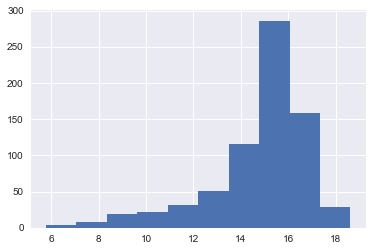

In [53]:
adjusted_outputs = [np.log(i) for i in np.abs(AU3_output) if i > 0]
plt.hist(adjusted_outputs)
max(adjusted_outputs), min(adjusted_outputs)

## Everything below this cell is experimental/debugging

In [ ]:
# RANDOM STUFF DELETE LATER

from statsmodels.tsa.arima_model import ARIMA
city1.tail()
before = city1[['Date', 'ZHVI_AllHomes']][city1['Date'] < '2017-08-31'].set_index(['Date'])['ZHVI_AllHomes']
model = ARIMA(endog=np.array(before, dtype=np.float), order=(5, 1, 1))
model_fit = model.fit(disp=0)
#np.array(before, dtype=np.float)[0]
#city1['dt'] = city1
#np.array(city1['Date'], dtype='datetime64')
model_fit.predict(before.shape[0], city1.shape[0])

In [ ]:
city1 = city1[city1['Date'] < "2012"]
d = lambda i: city1['ZHVI_AllHomes'].iloc[i] - city1['ZHVI_AllHomes'].iloc[i-1]
diffs = np.array([d(i) for i in range(1, len(city1))])
# reshape dataframe to include diffs
city1 = city1.iloc[1:]
city1['Diffs'] = diffs
city1['Diffs']
# find local maxes using diffs
is_max = np.array([(city1['Diffs'].iloc[i] >= 0) and (city1['Diffs'].iloc[i+1] <= 0) for i in range(len(city1) - 1)])
is_max = np.append(is_max, False)

# check for presence of local maxes at all
if np.count_nonzero(is_max) == 0:
    print(0)
# add 'is_maximum' truth column to dataframe
city1['Max'] = is_max
# filter and find largest max
theMax = city1[city1['Max'] == 1.0].sort_values("ZHVI_AllHomes", ascending=False).iloc[0]
start_date = theMax['Date']
start_date